# Exploratory Data Analysis (EDA)

Conducting EDA on the NBA MVP award share from 1982-2022 to examine relationships between award share (number of votes received) and other statistical categories. The data will also be examined to see what other stats contribute to a players success in the league. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

#Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Show plots inline
%matplotlib inline

In [2]:
#Importing data from the data wrangling phase
df = pd.read_csv('../data/df.csv')
mvp_contri = pd.read_csv('../data/mvp_contri.csv')
mvp_stats = pd.read_csv('../data/mvp_stats.csv')


First we're going to review each data frame that was saved from the data wrangling phase 

In [3]:
#Looking at the dataframe saved from the data wrangling phase
df.head()



,Unnamed: 0,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,...,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,...,10.7,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695
1,1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,...,7.2,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561
2,2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,...,1.9,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341
3,3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,...,0.5,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768
4,4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,...,5.2,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768


In [4]:
mvp_contri.head()

,Unnamed: 0,season,player,fg_per_g,pts_per_g,usg_pct,ws,ows,vorp,award_share
0,0,1982,Moses Malone,11.7,31.1,29.9,15.4,11.7,5.5,0.735
1,1,1983,Moses Malone,8.4,24.5,26.0,15.1,9.1,4.2,0.960
2,2,1984,Larry Bird,9.6,24.2,26.7,13.6,7.9,7.3,0.858
3,3,1985,Larry Bird,11.5,28.7,28.5,15.7,10.5,8.7,0.978
4,4,1986,Larry Bird,9.7,25.8,27.6,15.8,9.6,8.4,0.981


In [5]:
mvp_stats.head()

,Unnamed: 0,season,award_share,player,pos,age,team_id,g,gs,mp_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
0,0,1982,0.735,Moses Malone,C,26,HOU,81,81,42.0,...,3.7,15.4,0.218,6.2,-1.8,4.5,5.5,-0.04,-0.39,0.561
1,1,1983,0.960,Moses Malone,C,27,PHI,78,78,37.5,...,6.0,15.1,0.248,4.0,-0.3,3.7,4.2,7.67,7.53,0.793
2,2,1984,0.858,Larry Bird,PF,27,BOS,79,77,38.3,...,5.6,13.6,0.215,5.6,2.0,7.6,7.3,6.56,6.42,0.756
3,3,1985,0.978,Larry Bird,SF,28,BOS,80,77,39.5,...,5.2,15.7,0.238,6.8,2.0,8.8,8.7,6.65,6.47,0.768
4,4,1986,0.981,Larry Bird,SF,29,BOS,82,81,38.0,...,6.2,15.8,0.244,6.6,2.1,8.7,8.4,9.41,9.06,0.817


Next, we'll adjust all players stats to a 35-minute-per-game basis. This will allow the comparison of stats for players that have played different minutes on a per-minute basis, allowing for a more accurate comparison once the dataset is normalized and split for testing.

In [6]:
#Stripping the dataframe of string values in order to use a calculation function on the entire dataset
df_per_35 = df.select_dtypes(include=[np.number])


minutes_played = df_per_35['mp_per_g']

target_minutes = 35
df_per_35 = df_per_35.div(minutes_played, axis=0) * target_minutes

In [7]:
#Correcting column values that didn't need to be normalized 
df_per_35[['season','age','g','gs']] = df[['season','age','g','gs']]

In [8]:
#Adding back in string values
df_per_35['player'] = df['player']
df_per_35['team_id'] = df['team_id']
df_per_35['pos'] = df['pos']

In [9]:
#Setting the correct index so the new dataframe can match up to the old dataframe
df_per_35.insert(2,'player', df_per_35.pop('player'))
df_per_35.insert(5,'team_id',df_per_35.pop('team_id'))
df_per_35.insert(3,'pos',df_per_35.pop('pos'))

In [10]:
df_per_35.head()

,Unnamed: 0,season,player,pos,age,g,team_id,gs,mp_per_g,fg_per_g,...,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,0.000000,1982,Kareem Abdul-Jabbar,C,34,76,LAL,76,35.0,9.843750,...,10.639205,0.190909,3.778409,1.193182,4.971591,4.673295,0.044744,4.842330,4.345170,0.691051
1,1.155116,1982,Alvan Adams,C,27,79,PHO,75,35.0,7.392739,...,8.316832,0.166337,1.617162,2.541254,4.158416,3.927393,0.000000,3.985149,3.523102,0.648020
2,2.430556,1982,Mark Aguirre,SF,22,51,DAL,20,35.0,9.114583,...,2.309028,0.074132,2.795139,-1.944444,0.850694,1.215278,0.000000,-5.383681,-5.444444,0.414410
3,9.905660,1982,Danny Ainge,SG,22,53,BOS,1,35.0,4.952830,...,1.650943,0.138679,-12.216981,3.301887,-8.915094,-0.330189,0.000000,21.066038,20.966981,2.535849
4,4.388715,1982,Tiny Archibald,PG,33,68,BOS,51,35.0,4.937304,...,5.705329,0.126176,1.536050,-1.426332,0.109718,1.206897,0.000000,7.000000,6.967085,0.842633


In [11]:
#Dropping the Unnamed column
df_per_35.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df_per_35.head()

,season,player,pos,age,g,team_id,gs,mp_per_g,fg_per_g,fga_per_g,...,ws,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct
0,1982,Kareem Abdul-Jabbar,C,34,76,LAL,76,35.0,9.843750,17.002841,...,10.639205,0.190909,3.778409,1.193182,4.971591,4.673295,0.044744,4.842330,4.345170,0.691051
1,1982,Alvan Adams,C,27,79,PHO,75,35.0,7.392739,15.016502,...,8.316832,0.166337,1.617162,2.541254,4.158416,3.927393,0.000000,3.985149,3.523102,0.648020
2,1982,Mark Aguirre,SF,22,51,DAL,20,35.0,9.114583,19.565972,...,2.309028,0.074132,2.795139,-1.944444,0.850694,1.215278,0.000000,-5.383681,-5.444444,0.414410
3,1982,Danny Ainge,SG,22,53,BOS,1,35.0,4.952830,13.867925,...,1.650943,0.138679,-12.216981,3.301887,-8.915094,-0.330189,0.000000,21.066038,20.966981,2.535849
4,1982,Tiny Archibald,PG,33,68,BOS,51,35.0,4.937304,10.532915,...,5.705329,0.126176,1.536050,-1.426332,0.109718,1.206897,0.000000,7.000000,6.967085,0.842633


In [13]:
#Saving columns for easier use later
columns = ['season','player','pos',
           'age','team_id',
           'g','gs', 'award_share' ]
df_columns = mvp_stats[columns]


In [14]:
#Setting the mvp_stats data frame to a 35-minutes-per-game basis
mvp_per_35 = mvp_stats.select_dtypes(include=[np.number])


minutes_played = mvp_per_35['mp_per_g']

target_minutes = 35
mvp_per_35 = mvp_per_35.div(minutes_played, axis=0) * target_minutes

In [15]:
#Adding back in and correcting columns
mvp_per_35[['season','player','pos','age',
           'team_id','g',
           'gs', 'award_share']] = df_columns[['season','player','pos','age','team_id',
                                                           'g','gs', 'award_share']]

In [16]:
#Setting indexes
mvp_per_35.insert(2,'player', mvp_per_35.pop('player'))
mvp_per_35.insert(5,'team_id',mvp_per_35.pop('team_id'))
mvp_per_35.insert(3,'pos',mvp_per_35.pop('pos'))

In [17]:
#Dropping unnamed column 
mvp_per_35.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
mvp_per_35.head()

,season,player,pos,award_share,age,team_id,g,gs,mp_per_g,fg_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
0,1982,Moses Malone,C,0.735,26,HOU,81,81,35.0,9.750000,...,3.083333,12.833333,0.181667,5.166667,-1.500000,3.750000,4.583333,-0.033333,-0.325000,0.467500
1,1983,Moses Malone,C,0.960,27,PHI,78,78,35.0,7.840000,...,5.600000,14.093333,0.231467,3.733333,-0.280000,3.453333,3.920000,7.158667,7.028000,0.740133
2,1984,Larry Bird,PF,0.858,27,BOS,79,77,35.0,8.772846,...,5.117493,12.428198,0.196475,5.117493,1.827676,6.945170,6.671018,5.994778,5.866841,0.690862
3,1985,Larry Bird,SF,0.978,28,BOS,80,77,35.0,10.189873,...,4.607595,13.911392,0.210886,6.025316,1.772152,7.797468,7.708861,5.892405,5.732911,0.680506
4,1986,Larry Bird,SF,0.981,29,BOS,82,81,35.0,8.934211,...,5.710526,14.552632,0.224737,6.078947,1.934211,8.013158,7.736842,8.667105,8.344737,0.752500


The next step in this notebook is to look at past MVP winners with the largest award share. 90% was chosen as the target number for this test. Once this group is split out from the rest of the mvp winners, their stats will be analyized and compared to see if there is a pattern for players receiving 90% or more of the vote.

In [19]:
mvp_90 = mvp_per_35.copy()

In [20]:
mvp_90.drop(mvp_90[mvp_90['award_share'] <.90].index, inplace=True)

In [21]:
mvp_90.head()

,season,player,pos,award_share,age,team_id,g,gs,mp_per_g,fg_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
1,1983,Moses Malone,C,0.960,27,PHI,78,78,35.0,7.840000,...,5.600000,14.093333,0.231467,3.733333,-0.280000,3.453333,3.920000,7.158667,7.028000,0.740133
3,1985,Larry Bird,SF,0.978,28,BOS,80,77,35.0,10.189873,...,4.607595,13.911392,0.210886,6.025316,1.772152,7.797468,7.708861,5.892405,5.732911,0.680506
4,1986,Larry Bird,SF,0.981,29,BOS,82,81,35.0,8.934211,...,5.710526,14.552632,0.224737,6.078947,1.934211,8.013158,7.736842,8.667105,8.344737,0.752500
5,1987,Magic Johnson,PG,0.940,27,LAL,80,80,35.0,8.195592,...,3.663912,15.330579,0.253581,7.231405,1.253444,8.484848,7.713499,8.966942,8.022039,0.764601
9,1991,Michael Jordan,SG,0.928,27,CHI,82,82,35.0,11.445946,...,5.108108,19.202703,0.303649,8.418919,3.027027,11.351351,10.216216,8.608108,8.106757,0.703784


In [22]:
mvp_90.describe()

,season,award_share,age,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,2004.045455,0.962273,26.818182,77.772727,77.590909,35.0,9.651756,18.987589,0.484122,1.345017,...,4.922274,15.721546,0.264024,7.238402,2.062760,9.296820,8.066577,7.849979,7.517775,0.736463
std,12.677228,0.027826,2.630161,4.946685,4.885928,0.0,1.154625,1.854911,0.065072,1.352450,...,0.969599,2.332924,0.045242,1.697445,1.196354,2.497665,1.607320,2.234141,2.118676,0.083958
min,1983.000000,0.904000,22.000000,63.000000,63.000000,35.0,7.840000,15.586667,0.350000,0.000000,...,3.439306,9.833333,0.158333,3.733333,-0.280000,3.453333,3.920000,3.566667,3.025000,0.569167
25%,1993.000000,0.938500,25.000000,76.000000,76.000000,35.0,8.902895,18.042004,0.452052,0.365213,...,4.232022,14.327591,0.234006,6.050194,1.300591,8.044243,7.636961,6.022719,6.061832,0.680869
50%,2006.500000,0.965000,27.000000,80.000000,79.500000,35.0,9.436316,18.468651,0.465066,1.229771,...,4.768900,15.873421,0.268258,7.468488,1.876891,9.510369,8.097655,7.885850,7.690394,0.738559
75%,2014.750000,0.984750,28.000000,81.000000,81.000000,35.0,10.428417,20.623587,0.514308,1.518562,...,5.744608,17.291979,0.302077,8.494532,2.826809,11.024358,9.049041,9.304880,8.528638,0.776973
max,2021.000000,1.000000,34.000000,82.000000,82.000000,35.0,12.549342,22.680921,0.636678,5.219298,...,7.106599,19.202703,0.325439,10.540936,4.720395,13.240132,10.954907,11.605263,10.954907,0.910819


Looking at the summary statistics, the mean age is about 27 years old for past MVP winners with the highest award share. They make an average of 10 field goals per game (fg_per_g) and win about 74% of games they participate in on average.

Next, we will normalize the data and take a further look at the relationships between each data point

In [23]:
#Creating a new data frame and setting the index to player
mvp_90_scale = mvp_90.set_index('player')
#Saving the mvp labels into a variable
mvp_90_index = mvp_90_scale.index
#Saving the column names into a variable
mvp_90_columns = mvp_90_scale.columns
mvp_90_scale.head()


,season,pos,award_share,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
player,,,,,,,,,,,,,,,,,,,,,
Moses Malone,1983,C,0.960,27,PHI,78,78,35.0,7.840000,15.586667,...,5.600000,14.093333,0.231467,3.733333,-0.280000,3.453333,3.920000,7.158667,7.028000,0.740133
Larry Bird,1985,SF,0.978,28,BOS,80,77,35.0,10.189873,19.493671,...,4.607595,13.911392,0.210886,6.025316,1.772152,7.797468,7.708861,5.892405,5.732911,0.680506
Larry Bird,1986,SF,0.981,29,BOS,82,81,35.0,8.934211,18.052632,...,5.710526,14.552632,0.224737,6.078947,1.934211,8.013158,7.736842,8.667105,8.344737,0.752500
Magic Johnson,1987,PG,0.940,27,LAL,80,80,35.0,8.195592,15.812672,...,3.663912,15.330579,0.253581,7.231405,1.253444,8.484848,7.713499,8.966942,8.022039,0.764601
Michael Jordan,1991,SG,0.928,27,CHI,82,82,35.0,11.445946,21.189189,...,5.108108,19.202703,0.303649,8.418919,3.027027,11.351351,10.216216,8.608108,8.106757,0.703784


In [24]:
#Removing all columns that don't have a numeric value 
mvp_90_scale_normalized = mvp_90_scale.select_dtypes(include=[np.number])

In [25]:
#Subtracting the mean from each value in that column
mvp_90_scale_mean = mvp_90_scale_normalized.mean()
mvp_90_scale_normalized = mvp_90_scale_normalized - mvp_90_scale_mean

In [26]:
#Dividing each value in each column by the standard deviation of that column
mvp_90_scale_std = mvp_90_scale_normalized.std()
mvp_90_scale_normalized = mvp_90_scale_normalized / mvp_90_scale_std

In [27]:
mvp_90_scale_normalized.head()

,season,award_share,age,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
player,,,,,,,,,,,,,,,,,,,,,
Moses Malone,-1.660099,-0.081676,0.069128,0.045944,0.083728,NaN,-1.569130,-1.833470,-0.253902,-0.994504,...,0.698976,-0.697928,-0.719612,-2.064908,-1.958250,-2.339580,-2.579808,-0.309431,-0.231171,0.043720
Larry Bird,-1.502336,0.565195,0.449333,0.450256,-0.120941,NaN,0.466054,0.272833,-0.331790,-0.535890,...,-0.324545,-0.775916,-1.174507,-0.714654,-0.242912,-0.600302,-0.222554,-0.876209,-0.842443,-0.666481
Larry Bird,-1.423454,0.673006,0.829538,0.854567,0.697737,NaN,-0.621453,-0.504045,-0.419226,-0.313479,...,0.812968,-0.501051,-0.868362,-0.683058,-0.107451,-0.513945,-0.205146,0.365745,0.390320,0.191016
Magic Johnson,-1.344573,-0.800420,0.069128,0.450256,0.493067,NaN,-1.261158,-1.711628,0.294814,-0.923212,...,-1.297817,-0.167587,-0.230811,-0.004122,-0.676486,-0.325092,-0.219669,0.499952,0.238009,0.335143
Michael Jordan,-1.029046,-1.231667,0.069128,0.854567,0.902406,NaN,1.553916,1.186903,0.395612,-0.714732,...,0.191661,1.492186,0.875834,0.695467,0.806005,0.822581,1.337406,0.339338,0.277995,-0.389229


In [28]:
#Saving the names of columns for easier use later and readding them to the dataframe 
column_1 = ['fg_per_g','pts_per_g','usg_pct','ws','ows','vorp']
mvp_90_contri = mvp_90_scale_normalized[column_1]


In [29]:
def mutual_information_scores(df):
    ## Function designed to take a pd dataframe as input and calculate mutual information score between target and feature variables ##
    
    target = df.copy()
    features = df.drop('award_share',axis=1)
    
    #Creating target variable
    y = target['award_share']
    
    #Encoding for categoricals
    for column in features.select_dtypes("object"):
        features[column], _ = features[column].factorize()
    
    #Setting all discrete features to have an integer dtype
    discrete_features = features.dtypes == int
    
    #Calculating mutual information score between y and the features variable
    mi_score = mutual_info_regression(features,y,discrete_features='auto')
    #Saving the score to a pd dataframe
    mi_score = pd.Series(mi_score,name="MI Score",index=features.columns)
    #Sorting the series in descending order
    mi_score = mi_score.sort_values(ascending=False)
    
    
    return target,features, mi_score
    

In [30]:
#Removing unnecessary columns from the dataframe 
drop_mi = ['season', 'player', 'pos', 'age','team_id','g','gs',]
df_mi = mvp_90.copy()
df_mi.drop(drop_mi,axis=1,inplace=True)

In [31]:
#Calling the function and saving it's results to variables for use later
feature,target,mi_score = mutual_information_scores(df=df_mi)

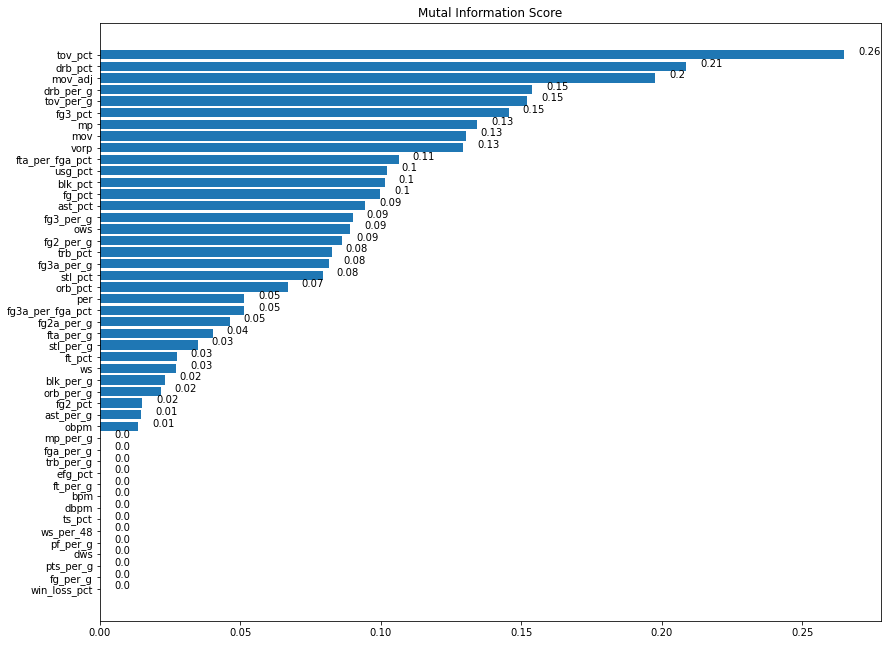

In [32]:
def show_mi_scores(scores, figsize):
    ##Function used to visualize the mutal information scores from the mutual_information_score function results##
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig,ax, = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    #Plotting text labels on top of graph and setting the positioning of labels
    for index,value in enumerate(scores):
        plt.text(value +0.005, index, str(round(value,2)))
    
    #Setting the y-axis labels to be the names of the features and setting the chart title    
    plt.yticks(width, ticks)
    plt.title("Mutal Information Score")
    
#Calling the function using the results from the mutual_information_scores function
show_mi_scores(mi_score, figsize=(14,11))


The mutual information scores table above uses the award_share column as the target variable and all other columns in the data frame are considered features. The function called above then performs factorization on the categorical features to convert them into numerical values and sets all discrete features to have an integer dtype. 

The mutual information regression call calculates the mutual information scores defined above between the target variable and the features selected. 

Based on the table above, tunrover percentage (tov_pct) has a strong relationship to the award share in MVP voting. Also, as expected from the heat map used in the data wrangling phase, value over replacement player (vorp) and usage percentage (usg_pct) are also strongly related to award share.

The last step in this phase is to view some of the new found mutual information scores as a scatter plot against the feature award_share. This will help to visualize the direct relationship for all players in the data frame between the feature selected and the target variable. 

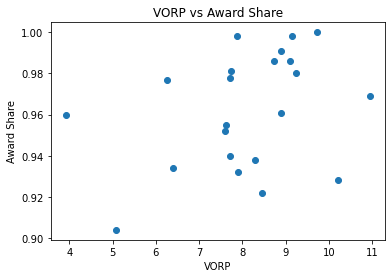

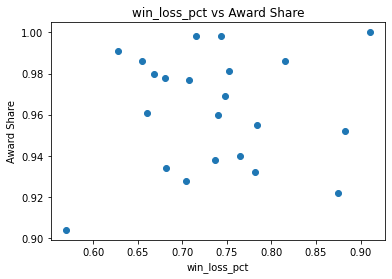

In [33]:
#Creating a scatter plot to visualize the relationship between the target variable award_share and features 
plt.scatter(feature['vorp'], feature['award_share'])
plt.xlabel('VORP')
plt.ylabel('Award Share')
plt.title('VORP vs Award Share')
plt.show()

plt.scatter(feature['win_loss_pct'], feature['award_share'])
plt.xlabel('win_loss_pct')
plt.ylabel('Award Share')
plt.title('win_loss_pct vs Award Share')
plt.show()

The results from the VORP vs Award Share scatter plots shows us there's a limit to how much value is placed on the VORP metric. Around the 70-80 percent range the positive relationship with award_share begins to plummet. A VORP over 80 doesn't yield much higher award shares.

The win_loss_pct vs Award Share scatter plots tells a similar story, after a certain percentage the relationship begins to fade. The range of 70-80 percentage seems to be the ideal target here also. 

In [34]:
#Saving the updated models to csv
mvp_per_35.to_csv(r'C:/Users/bartl/Desktop/Data-Science-/Capstone 2/data/mvp_per_35.csv')
mvp_90_scale_normalized.to_csv(r'C:/Users/bartl/Desktop/Data-Science-/Capstone 2/data/mvp_90_scale_normalized.csv')
df_per_35.to_csv(r'C:/Users/bartl/Desktop/Data-Science-/Capstone 2/data/df_per_35.csv')
mvp_90_contri.to_csv(r'C:/Users/bartl/Desktop/Data-Science-/Capstone 2/data/mvp_90_contri.csv')

# Conclusion

During this phase of the project, the previously created data sets from the data wrangling phase were further explored. Four key data sets were created; mvp_per_35, df_per_35, mvp_90_contri and mvp_90_scale_normalized. Each data set has been adjusted to a 35 minute-per game basis for all stat categories allowing for more accurate comparisons of the data. The data was further validated by normalizing each data set, this will help when splitting and training the data. 

After calculating the mutual information scores, using award_share as the target variable and all other columns are features, we were able to establish a stronger relationship between award_share and each variable in the dataframe. Further analysis shows that the relationship between award share and any one variable begins to decline after a certain point.


